In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse

from keras import utils
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Layer, Input, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Reshape, Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Concatenate, Bidirectional, GRU

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Подготовка данных**

In [5]:
data = pd.read_csv('/content/drive/MyDrive/диссертация/data/data_preprocessing_final.csv')

<ipython-input-5-390fa1bd4d89>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/МАГИСТЕРСКАЯ/data_preprocessing_final.csv')


In [6]:
del data['Unnamed: 0']
data.head()

,id,diary,text,date,sex,birth,age,text_preprocessing
0,693,3,Сейчас бьет на башенных часах 12. Полночь. Жен...,1932-09-28,1.0,1890-05-25,42.0,бить башенный часы полночь жена спать ребенок ...
1,694,3,"Читал Шаляпина — воспоминания. Оказывается, ис...",1932-10-06,1.0,1890-05-25,42.0,читать шаляпин воспоминание оказываться истори...
2,695,3,При социализме заводы суть храмы и центры чело...,1932-10-20,1.0,1890-05-25,42.0,социализм завод храм центр человеческий житие ...
3,696,3,Завтра с утра — в Москву. Что-то меня там ждет...,1932-10-30,1.0,1890-05-25,42.0,завтра утро москва ждать каково настроение шир...
4,697,3,"В Берлине, в полпредстве, оказался Горький (пр...",1932-11-01,1.0,1890-05-25,42.0,берлин полпредство оказываться горький проезд ...


In [7]:
data['date'].describe()

count         437230
unique         68366
top       1954-01-01
freq             450
Name: date, dtype: object

In [8]:
# Преобразуем столбец "date" в формат даты
data['date'] = pd.to_datetime(data['date'])

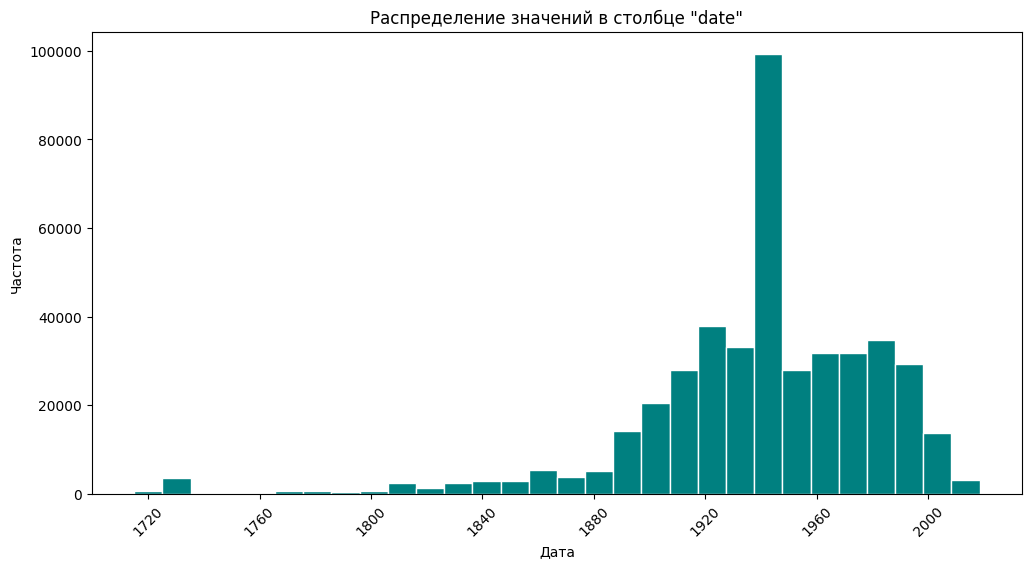

In [9]:
# Построение гистограммы распределения значений по дате
plt.figure(figsize=(12, 6))
plt.hist(data['date'], bins=30, color='teal', edgecolor='white')
plt.title('Распределение значений в столбце "date"')
plt.xlabel('Дата')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.show()

In [10]:
data['year'] = data['date'].dt.year

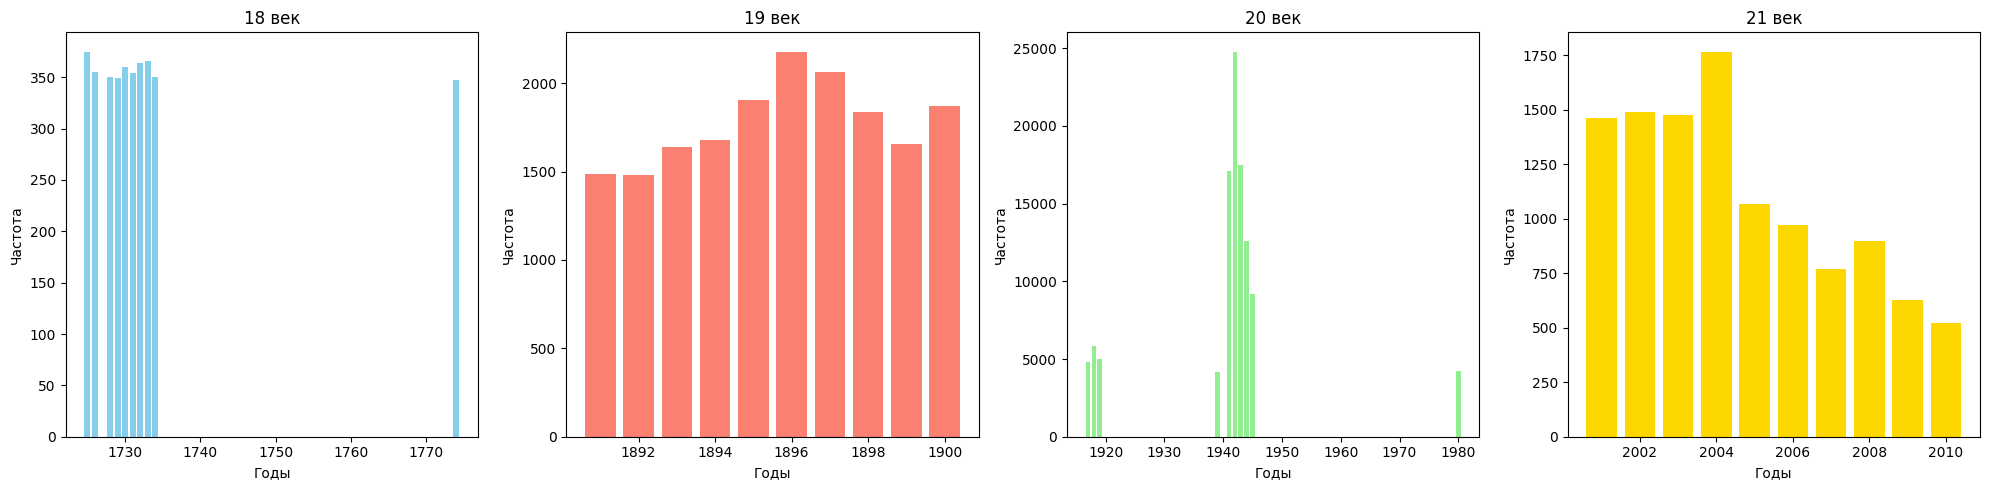

In [11]:
data['century'] = ((data['year'] - 1) // 100 + 1) * 100

# Считаем количество записей по столетиям
century_counts = data['century'].value_counts().sort_index()

# Фильтруем данные для каждого столетия
df_18th = data[data['century'] == 1800]
df_19th = data[data['century'] == 1900]
df_20th = data[data['century'] == 2000]
df_21st = data[data['century'] == 2100]

# Создаем subplot с четырьмя графиками
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# График для 18 века
axs[0].bar(df_18th['year'].value_counts().index[:10], df_18th['year'].value_counts().values[:10], color='skyblue')
axs[0].set_title('18 век')
axs[0].set_xlabel('Годы')
axs[0].set_ylabel('Частота')

# График для 19 века
axs[1].bar(df_19th['year'].value_counts().index[:10], df_19th['year'].value_counts().values[:10], color='salmon')
axs[1].set_title('19 век')
axs[1].set_xlabel('Годы')
axs[1].set_ylabel('Частота')

# График для 20 века
axs[2].bar(df_20th['year'].value_counts().index[:10], df_20th['year'].value_counts().values[:10], color='lightgreen')
axs[2].set_title('20 век')
axs[2].set_xlabel('Годы')
axs[2].set_ylabel('Частота')

# График для 21 века
axs[3].bar(df_21st['year'].value_counts().index[:10], df_21st['year'].value_counts().values[:10], color='gold')
axs[3].set_title('21 век')
axs[3].set_xlabel('Годы')
axs[3].set_ylabel('Частота')

plt.tight_layout()
plt.show()

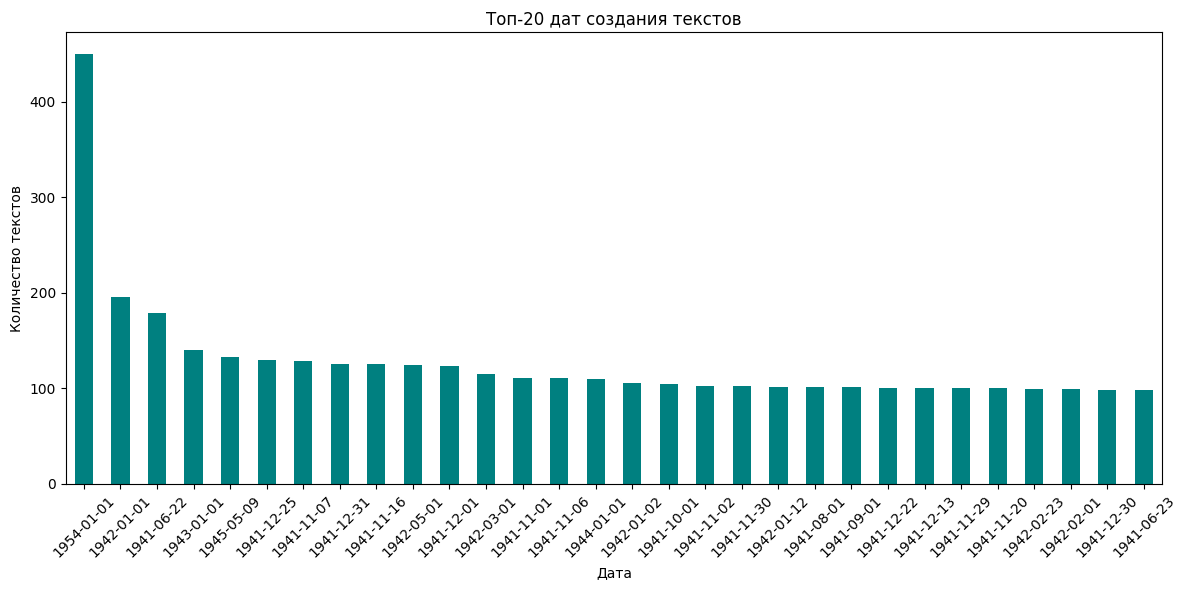

In [12]:
# Преобразуем даты и времена в даты
data['date'] = data['date'].dt.date

# Получаем топ-20 дат с наибольшим количеством текстов
top_dates = data['date'].value_counts().head(30)

plt.figure(figsize=(12, 6))
top_dates.plot(kind='bar', color='teal')
plt.title('Топ-20 дат создания текстов')
plt.xlabel('Дата')
plt.ylabel('Количество текстов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
data.head(5)

,id,diary,text,date,sex,birth,age,text_preprocessing,year,century
0,693,3,Сейчас бьет на башенных часах 12. Полночь. Жен...,1932-09-28,1.0,1890-05-25,42.0,бить башенный часы полночь жена спать ребенок ...,1932,2000
1,694,3,"Читал Шаляпина — воспоминания. Оказывается, ис...",1932-10-06,1.0,1890-05-25,42.0,читать шаляпин воспоминание оказываться истори...,1932,2000
2,695,3,При социализме заводы суть храмы и центры чело...,1932-10-20,1.0,1890-05-25,42.0,социализм завод храм центр человеческий житие ...,1932,2000
3,696,3,Завтра с утра — в Москву. Что-то меня там ждет...,1932-10-30,1.0,1890-05-25,42.0,завтра утро москва ждать каково настроение шир...,1932,2000
4,697,3,"В Берлине, в полпредстве, оказался Горький (пр...",1932-11-01,1.0,1890-05-25,42.0,берлин полпредство оказываться горький проезд ...,1932,2000


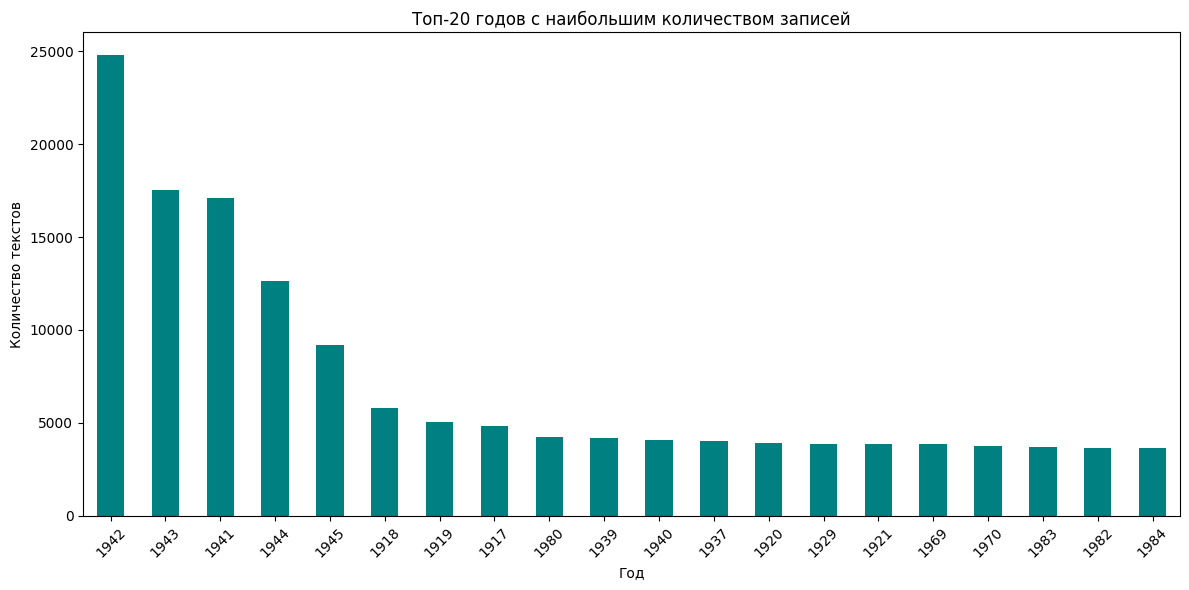

In [14]:
#data['year'] = data['date'].dt.year

# Получаем топ-20 годов с наибольшим количеством записей
top_years = data['year'].value_counts().head(20)

plt.figure(figsize=(12, 6))
top_years.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Топ-20 годов с наибольшим количеством записей')
plt.xlabel('Год')
plt.ylabel('Количество текстов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
data['century'] = data['century'].astype(str).str[:-2].astype(int)

In [16]:
# Подсчитываем количество записей в каждом столетии
century_counts = data['century'].value_counts().sort_index()

print("Количество записей в каждом столетии:")
print(century_counts)

Количество записей в каждом столетии:
century
18      5968
19     47551
20    371285
21     12426
Name: count, dtype: int64


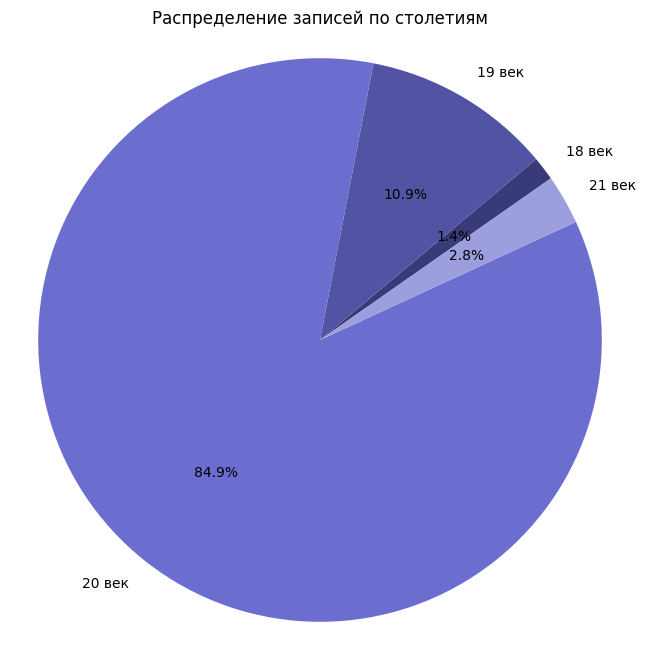

In [17]:
century_counts = data['century'].value_counts().sort_index()

# Выбор цветовой палитры
colors = plt.cm.tab20b.colors

labels_with_century = [str(century) + ' век' for century in century_counts.index]

# Создаем круговую диаграмму с улучшениями
plt.figure(figsize=(8, 8))
plt.pie(century_counts, labels=labels_with_century, autopct='%1.1f%%', startangle=35, colors=colors, textprops={'color': 'black'})
plt.axis('equal')  # Задаем равные пропорции для круговой диаграммы
plt.title('Распределение записей по столетиям')
plt.show()

In [18]:
# Создаем функцию для определения периода по дате
def define_period(date):
    year = date.year
    if year >= 1700 and year <= 1799:
        return '1700-1799'
    elif year >= 1800 and year <= 1899:
        return '1800-1899'
    elif year >= 1900 and year <= 1920:
        return '1900-1920'
    elif year >= 1921 and year <= 1940:
      return '1921-1940'
    elif year >= 1941 and year <= 1945:
        return '1941-1945'
    elif year >= 1946 and year <= 1960:
        return '1946-1960'
    elif year >= 1961 and year <= 1979:
        return '1961-1979'
    elif year >= 1980 and year <= 1999:
        return '1980-1999'
    elif year >= 2000 and year <= 2018:
        return '2000-2018'
    else:
        return 'Other'

# Применяем функцию к столбцу 'date' и создаем новый столбец 'period'
data['period'] = data['date'].apply(define_period)

# Получаем статистику по группам
statistics = data['period'].value_counts()

print(statistics)

period
1941-1945    81238
1921-1940    66752
1900-1920    60996
1961-1979    60438
1980-1999    60160
1800-1899    45698
1946-1960    41651
2000-2018    14348
1700-1799     5949
Name: count, dtype: int64


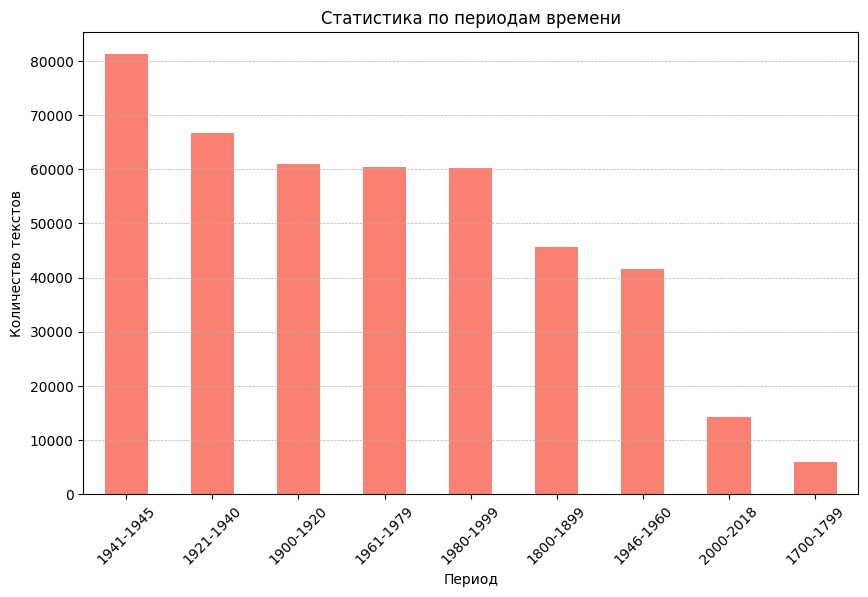

In [19]:
plt.figure(figsize=(10, 6))
statistics.plot(kind='bar', color='salmon')
plt.title('Статистика по периодам времени')
plt.xlabel('Период')
plt.ylabel('Количество текстов')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

# **Эксперименты по определению временного периода создания текста с помощью классических алгоритмов МО**

## **№1: LogitRegression**

In [ ]:
data.head()

,Unnamed: 0,id,diary,text,date,sex,birth,age,text_preprocessing,year,century,period
0,0,693,3,Сейчас бьет на башенных часах 12. Полночь. Жен...,1932-09-28,1.0,1890-05-25,42.0,бить башенный часы полночь жена спать ребенок ...,1932,20,1921-1940
1,1,694,3,"Читал Шаляпина — воспоминания. Оказывается, ис...",1932-10-06,1.0,1890-05-25,42.0,читать шаляпин воспоминание оказываться истори...,1932,20,1921-1940
2,2,695,3,При социализме заводы суть храмы и центры чело...,1932-10-20,1.0,1890-05-25,42.0,социализм завод храм центр человеческий житие ...,1932,20,1921-1940
3,3,696,3,Завтра с утра — в Москву. Что-то меня там ждет...,1932-10-30,1.0,1890-05-25,42.0,завтра утро москва ждать каково настроение шир...,1932,20,1921-1940
4,4,697,3,"В Берлине, в полпредстве, оказался Горький (пр...",1932-11-01,1.0,1890-05-25,42.0,берлин полпредство оказываться горький проезд ...,1932,20,1921-1940


In [ ]:
# Разделение на признаки и целевую переменную
X = data['text_preprocessing']
y = data['period']

# Разделение на обучающую и тестовую выборки
#y = np.array([val if val is not None else '' for val in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Заменяем все значения NaN пустой строкой
X_train.fillna('', inplace=True)
X_test.fillna('', inplace=True)

# Векторизация текста
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Предсказания на тестовых данных
y_pred = model.predict(X_test_vec)

# Оценка модели
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

   1700-1799       0.94      0.85      0.89      1190
   1800-1899       0.74      0.77      0.75      9139
   1900-1920       0.74      0.72      0.73     12199
   1921-1940       0.66      0.71      0.68     13350
   1941-1945       0.77      0.80      0.79     16248
   1946-1960       0.65      0.53      0.58      8330
   1961-1979       0.65      0.65      0.65     12088
   1980-1999       0.65      0.70      0.67     12032
   2000-2018       0.67      0.44      0.53      2870

    accuracy                           0.70     87446
   macro avg       0.72      0.69      0.70     87446
weighted avg       0.70      0.70      0.70     87446

Точность модели: 0.7006266724607186


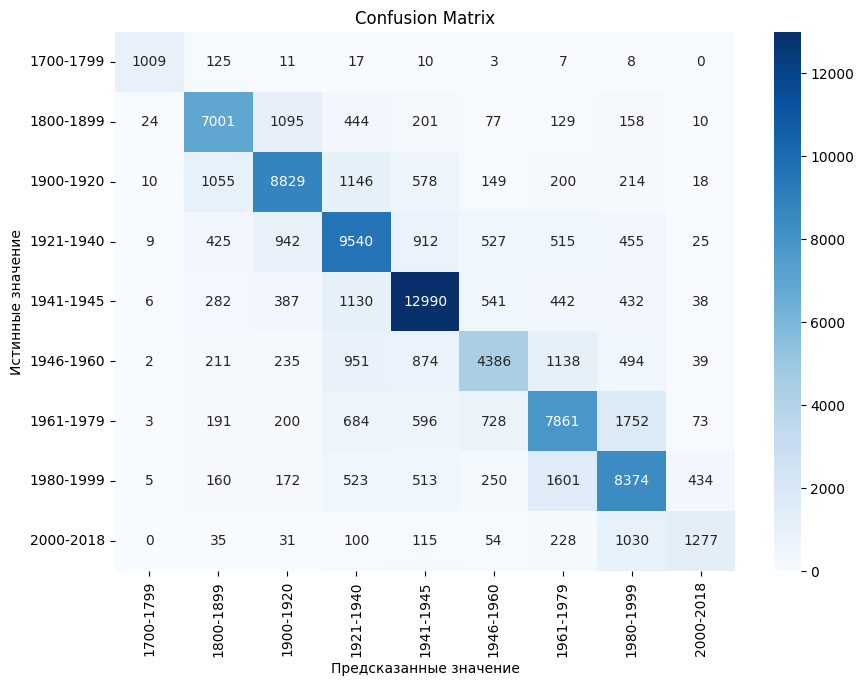

In [ ]:
# Вычисление матрицы ошибок
conf_mat = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Предсказанные значение')
plt.ylabel('Истинные значение')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Получение важных слов
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_.flatten()[:445772]

print(len(feature_names), len(coefficients))

# Создание DataFrame с результатами
importance_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})

# Сортировка по важности
importance_df = importance_df.sort_values(by='coefficient', ascending=False)

# Вывод самых важных слов
print("Слова, которые больше всего повлияли на принятие решений модели:")
print(importance_df.head(30))

445772 445772
Слова, которые больше всего повлияли на принятие решений модели:
              word  coefficient
424764       число    17.206705
238311         ноч    15.316228
46429       верста    11.585716
346358         сей    11.113796
240491  обедалисмо    10.559762
158155       князь    10.037958
240501     обедать     9.675465
316307       пяток     9.501447
371528       субот     9.392400
251023        оный     9.164286
76317       глухов     7.816637
240482        обед     7.696985
107407      ездиль     7.460729
423455      четвер     6.796343
55462       вовтор     6.532108
290611   понеделка     6.205642
87022         даль     6.011806
76923           го     6.011034
322630        рано     5.899140
328809       рибас     5.675883
203475        миля     5.651176
240498     обедаль     5.635448
343947     светлий     5.498548
348767      середа     5.448058
274638       писмо     5.419316
274468      писаль     5.275989
413288     хмарный     5.218976
167747     который     5.

## **№2: Multinominal Naive Bayes**

In [ ]:
# Предобработка текста (предполагается, что текст уже предобработан и находится в столбце 'text_preprocessing')
X = data['text_preprocessing']
y = data['period']

X.fillna('', inplace=True)

# Преобразование текста в матрицу признаков
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Разделение данных на обучающий и тестовый наборы
#y = np.array([val if val is not None else '' for val in y])
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Инициализация и обучение модели наивного Байеса
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = nb_model.predict(X_test)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')
print(classification_report(y_test, y_pred))

Точность модели: 0.667360428149944
              precision    recall  f1-score   support

   1700-1799       0.91      0.73      0.81      1190
   1800-1899       0.84      0.59      0.69      9139
   1900-1920       0.66      0.76      0.71     12199
   1921-1940       0.67      0.67      0.67     13350
   1941-1945       0.68      0.85      0.76     16248
   1946-1960       0.57      0.39      0.46      8330
   1961-1979       0.63      0.62      0.62     12088
   1980-1999       0.62      0.74      0.68     12032
   2000-2018       0.86      0.14      0.24      2870

    accuracy                           0.67     87446
   macro avg       0.72      0.61      0.63     87446
weighted avg       0.68      0.67      0.66     87446



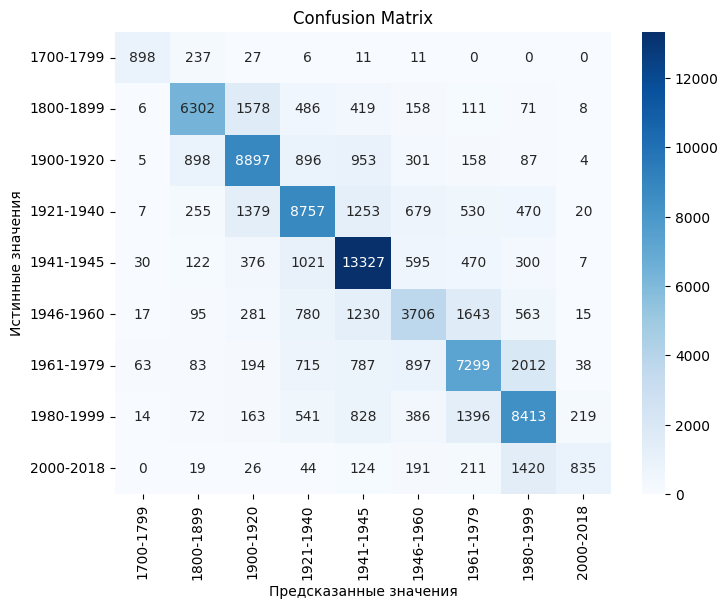

In [ ]:
# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Отображение матрицы ошибок в виде тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Confusion Matrix')
plt.show()

# **Эксперименты по определению временного периода создания текста с помощью методов глубинного обучения**

## **Подготовка к обучению модели**

In [20]:
# Токенизация текста
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
texts = data['text_preprocessing'].astype(str)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

In [21]:
# Конвертация текстов в последовательности
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

In [43]:
# Подготовка целевой переменной
labels = pd.get_dummies(data['period']).values

In [44]:
# Разбиение на тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)

## **№1: CNN1D**

In [ ]:
model_1 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_1 = model_1.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/35
5212/5212 [==============================] - 104s 19ms/step - loss: 1.4205 - accuracy: 0.4482 - val_loss: 1.1462 - val_accuracy: 0.5582 - lr: 0.0010
Epoch 2/35
5212/5212 [==============================] - 47s 9ms/step - loss: 1.1674 - accuracy: 0.5588 - val_loss: 1.0752 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 3/35
5212/5212 [==============================] - 44s 8ms/step - loss: 1.0823 - accuracy: 0.5926 - val_loss: 1.0483 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 4/35
5212/5212 [==============================] - 43s 8ms/step - loss: 1.0183 - accuracy: 0.6172 - val_loss: 1.0346 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 5/35
5212/5212 [==============================] - 44s 8ms/step - loss: 0.9587 - accuracy: 0.6392 - val_loss: 1.0345 - val_accuracy: 0.6101 - lr: 0.0010
Epoch 6/35
5212/5212 [==============================] - 45s 9ms/step - loss: 0.9053 - accuracy: 0.6596 - val_loss: 1.0324 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 7/35
5212/5212 [============================

2606/2606 [==============================] - 9s 3ms/step - loss: 1.1213 - accuracy: 0.6095
Функционал ошибки: 1.1212656497955322 
Точность модели: 0.6095194816589355


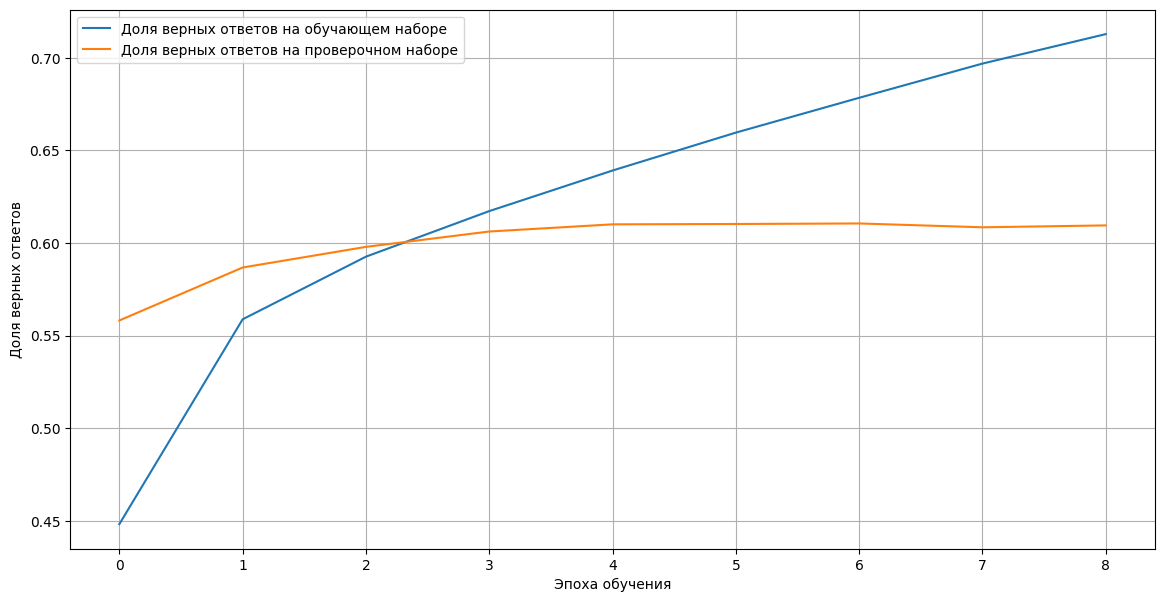

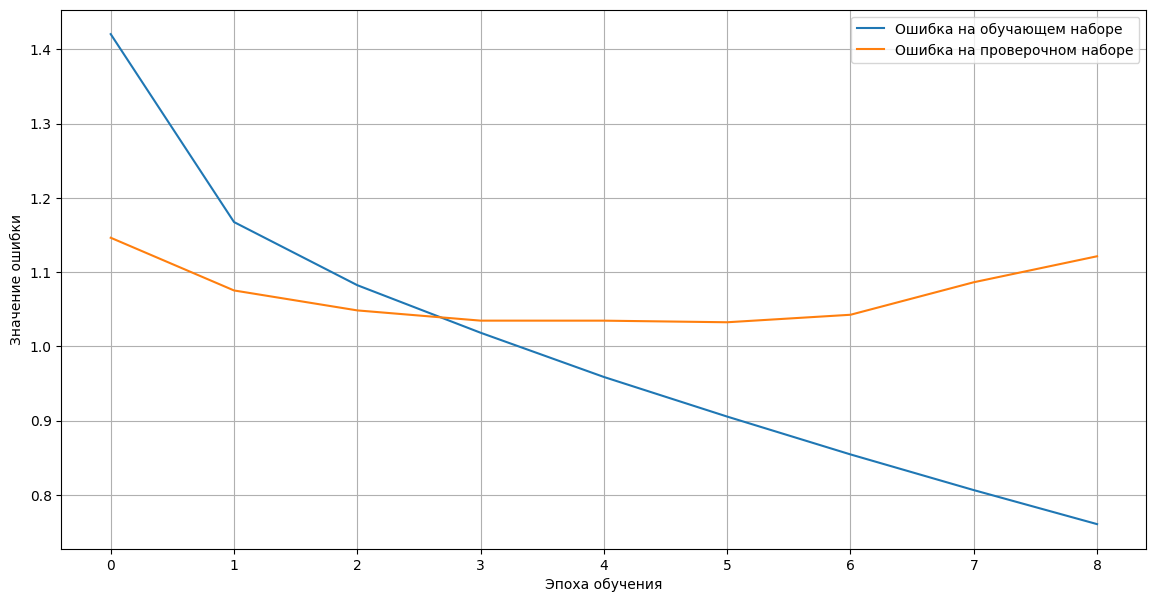

In [ ]:
val_loss, val_accuracy = model_1.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

plt.figure(figsize=(14,7))
plt.plot(history_1.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_1.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history_1.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_1.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model_1.save('model_time_period_CNN1D.h5')

## **№2: LSTM + CNN1D**

In [ ]:
model_2 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.4),

    Conv1D(256, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.4),

    Reshape((1, -1)),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.4),

    Dense(256, activation='relu'),
    Dropout(0.4),

    Dense(9, activation='softmax')
])

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_2 = model_2.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/35
5212/5212 [==============================] - 124s 21ms/step - loss: 1.3904 - accuracy: 0.4467 - val_loss: 1.1679 - val_accuracy: 0.5459 - lr: 0.0010
Epoch 2/35
5212/5212 [==============================] - 63s 12ms/step - loss: 1.1875 - accuracy: 0.5456 - val_loss: 1.1030 - val_accuracy: 0.5735 - lr: 0.0010
Epoch 3/35
5212/5212 [==============================] - 55s 11ms/step - loss: 1.1345 - accuracy: 0.5685 - val_loss: 1.0740 - val_accuracy: 0.5859 - lr: 0.0010
Epoch 4/35
5212/5212 [==============================] - 51s 10ms/step - loss: 1.1033 - accuracy: 0.5810 - val_loss: 1.0580 - val_accuracy: 0.5941 - lr: 0.0010
Epoch 5/35
5212/5212 [==============================] - 54s 10ms/step - loss: 1.0827 - accuracy: 0.5894 - val_loss: 1.0424 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 6/35
5212/5212 [==============================] - 51s 10ms/step - loss: 1.0650 - accuracy: 0.5974 - val_loss: 1.0288 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 7/35
5212/5212 [=======================

2606/2606 [==============================] - 11s 4ms/step - loss: 1.0058 - accuracy: 0.6180
Функционал ошибки: 1.0058445930480957 
Точность модели: 0.6179620027542114


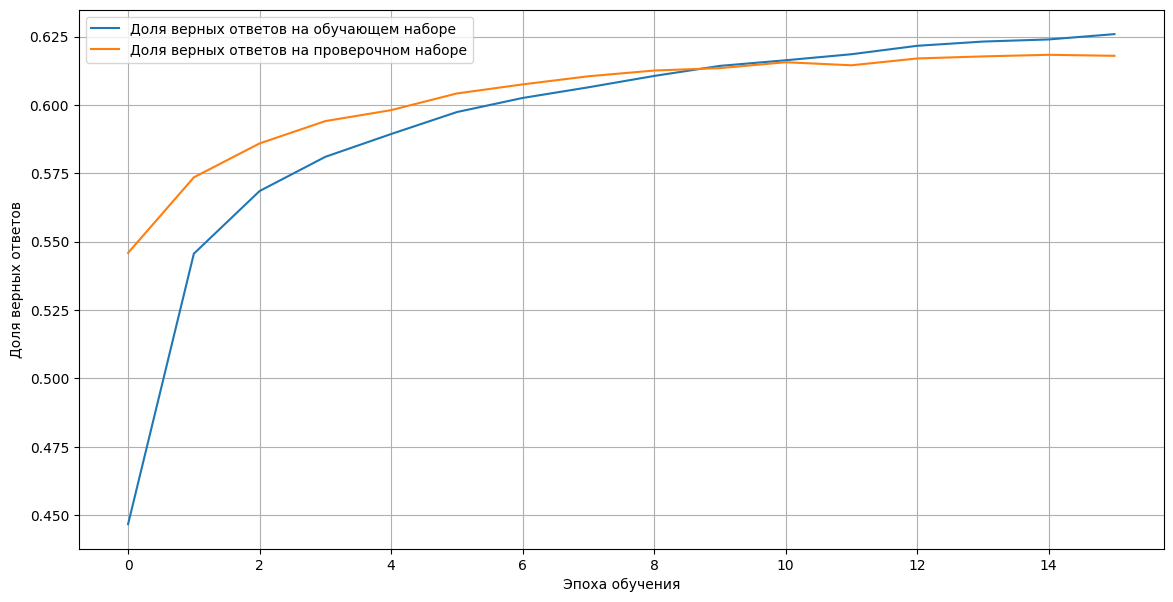

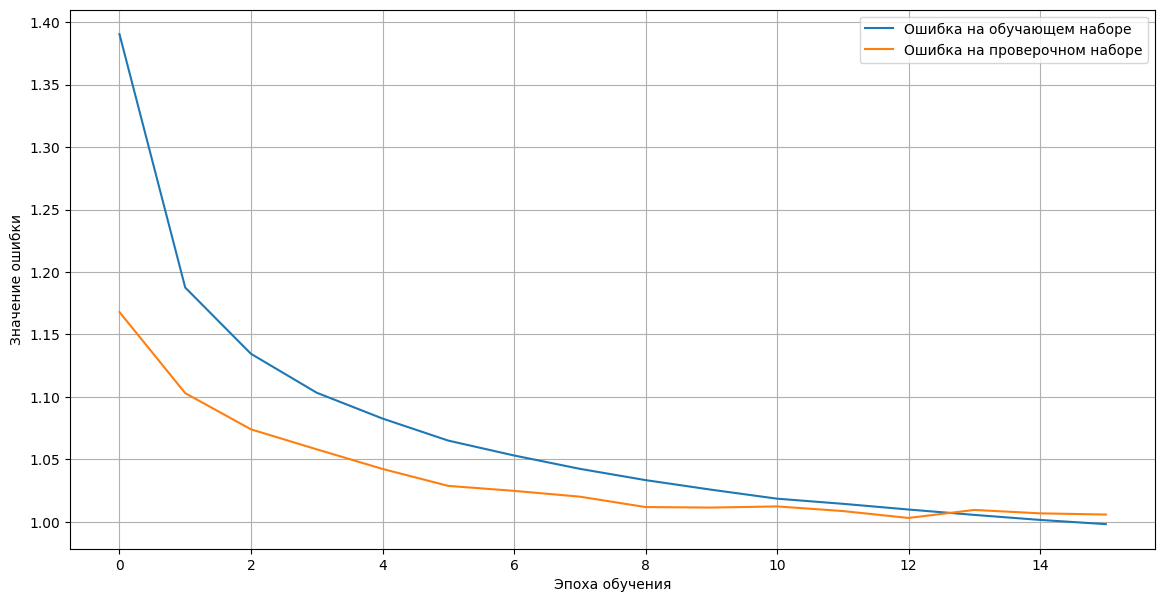

In [ ]:
val_loss, val_accuracy = model_2.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

plt.figure(figsize=(14,7))
plt.plot(history_2.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_2.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history_2.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_2.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model_2.save('model_time_period_CNN1D_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **№3: BiLSTM + LSTM**

In [45]:
model_3 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.4),
    BatchNormalization(),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    Dense(9, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_3 = model_3.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/35
5466/5466 [==============================] - 189s 33ms/step - loss: 0.4854 - accuracy: 0.6960 - val_loss: 0.4712 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 2/35
5466/5466 [==============================] - 127s 23ms/step - loss: 0.4705 - accuracy: 0.7053 - val_loss: 0.4635 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 3/35
5466/5466 [==============================] - 125s 23ms/step - loss: 0.4661 - accuracy: 0.6940 - val_loss: 0.4618 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 4/35
5466/5466 [==============================] - 136s 25ms/step - loss: 0.4652 - accuracy: 0.6859 - val_loss: 0.4603 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 5/35
5466/5466 [==============================] - 126s 23ms/step - loss: 0.4658 - accuracy: 0.6805 - val_loss: 0.4599 - val_accuracy: 0.6381 - lr: 0.0010
Epoch 6/35
5466/5466 [==============================] - 135s 25ms/step - loss: 0.4664 - accuracy: 0.6783 - val_loss: 0.4607 - val_accuracy: 0.6559 - lr: 0.0010
Epoch 7/35
5466/5466 [==================

2644/2644 [==============================] - 21s 8ms/step - loss: 0.9248 - accuracy: 0.6613
Функционал ошибки: 0.9248148798942566 
Точность модели: 0.6613027453422546


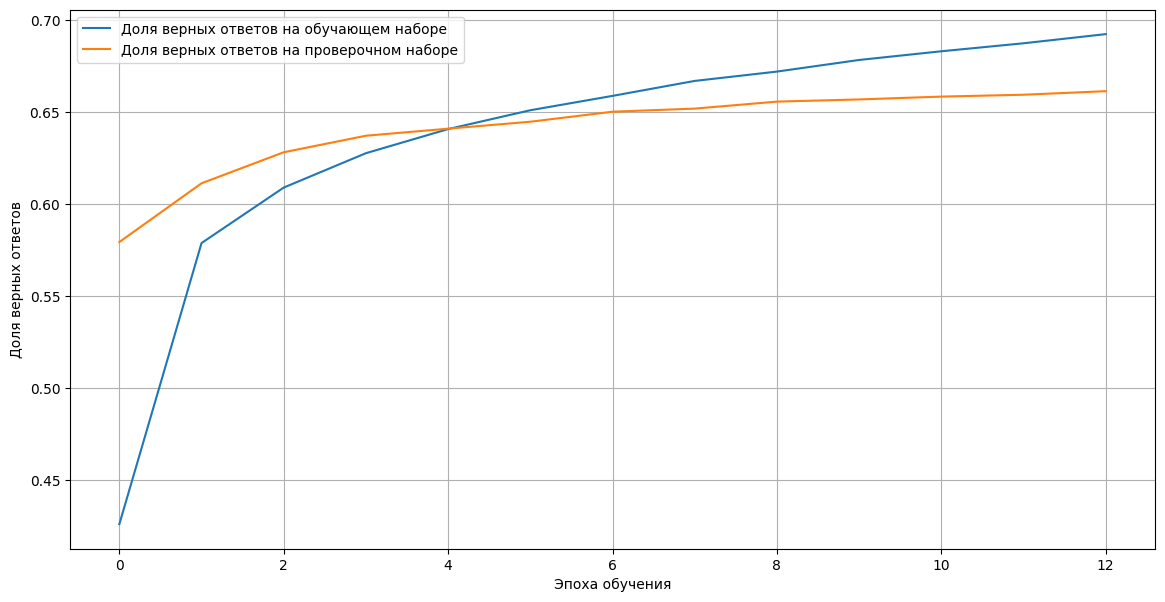

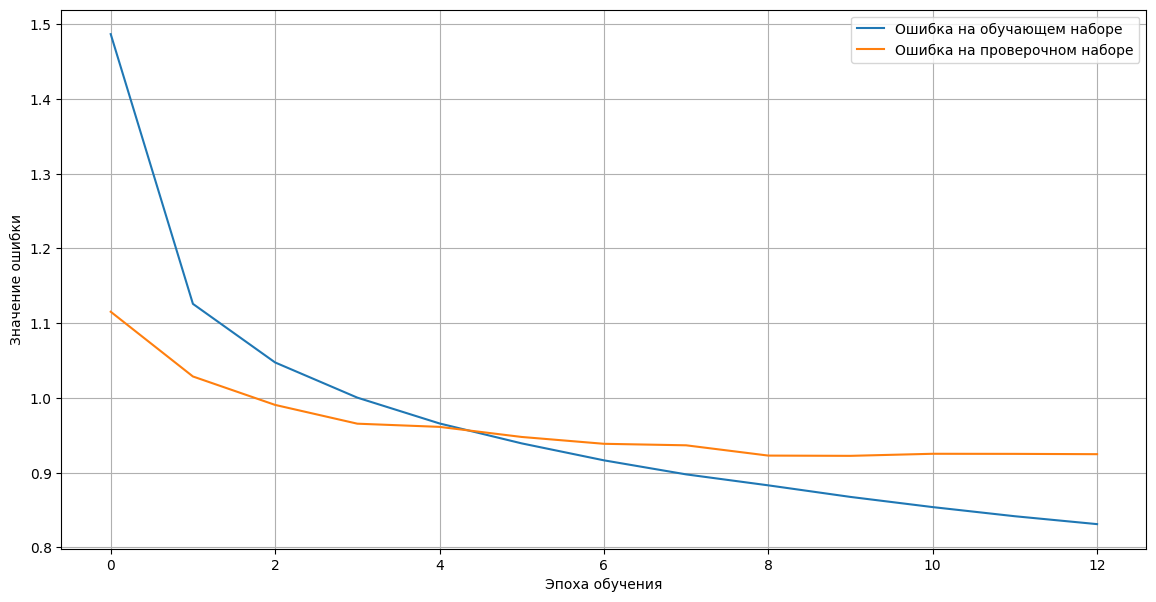

In [ ]:
val_loss, val_accuracy = model_3.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

plt.figure(figsize=(14,7))
plt.plot(history_3.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_3.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history_3.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_3.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model_3.save('model_time_period_LSTM_BiLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Усложненная архитектура**

In [ ]:
model_4 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.4),
    BatchNormalization(),

    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(9, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model_4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_4 = model_4.fit(X_train, y_train, epochs=35, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/35
5212/5212 [==============================] - 264s 48ms/step - loss: 1.6583 - accuracy: 0.3273 - val_loss: 1.3213 - val_accuracy: 0.4715 - lr: 0.0010
Epoch 2/35
5212/5212 [==============================] - 199s 38ms/step - loss: 1.2825 - accuracy: 0.5017 - val_loss: 1.1668 - val_accuracy: 0.5515 - lr: 0.0010
Epoch 3/35
5212/5212 [==============================] - 198s 38ms/step - loss: 1.1813 - accuracy: 0.5534 - val_loss: 1.1156 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 4/35
5212/5212 [==============================] - 197s 38ms/step - loss: 1.1204 - accuracy: 0.5779 - val_loss: 1.0561 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 5/35
5212/5212 [==============================] - 198s 38ms/step - loss: 1.0803 - accuracy: 0.5946 - val_loss: 1.0357 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 6/35
5212/5212 [==============================] - 198s 38ms/step - loss: 1.0503 - accuracy: 0.6065 - val_loss: 1.0178 - val_accuracy: 0.6132 - lr: 0.0010
Epoch 7/35
5212/5212 [==================

2606/2606 [==============================] - 45s 17ms/step - loss: 0.9440 - accuracy: 0.6466
Функционал ошибки: 0.9439519643783569 
Точность модели: 0.6465516090393066


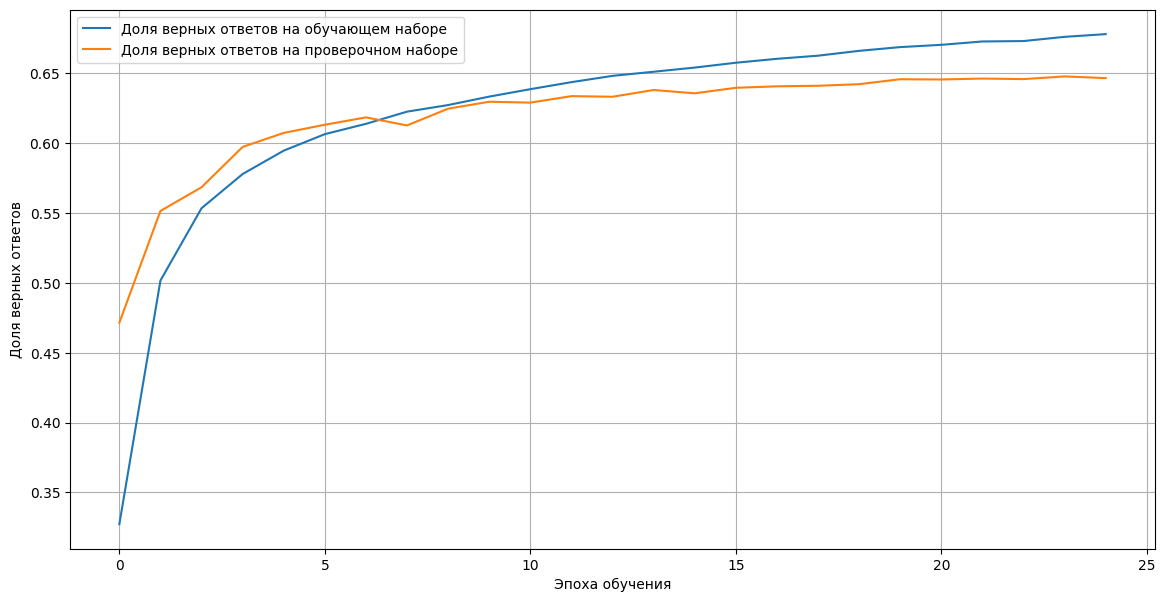

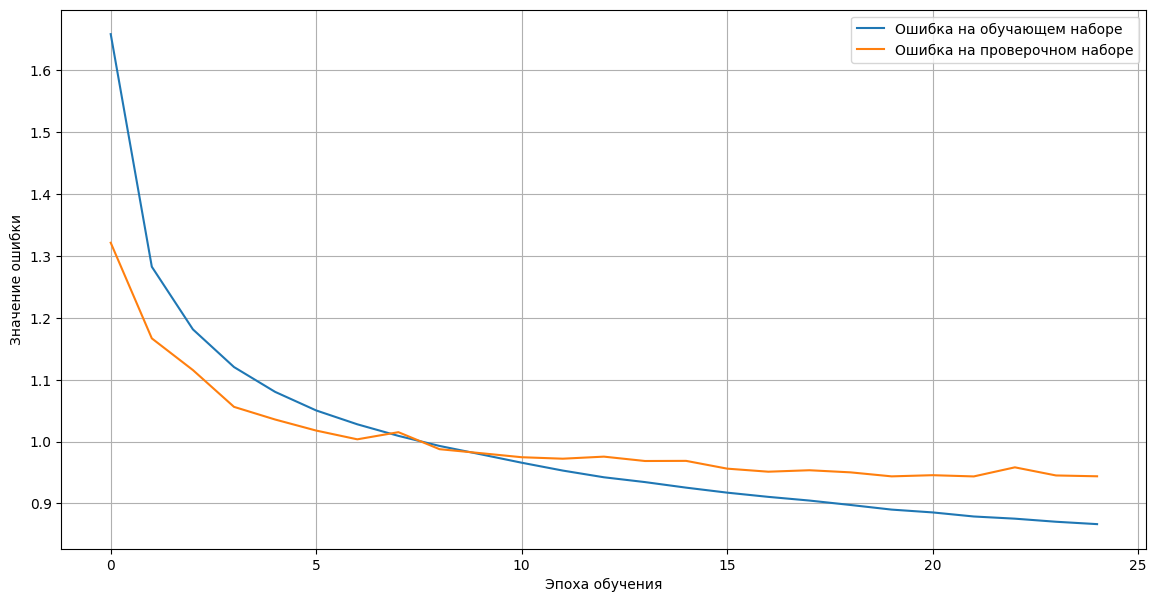

In [ ]:
val_loss, val_accuracy = model_4.evaluate(X_test, y_test)
print('Функционал ошибки: {} \nТочность модели: {}'.format(val_loss, val_accuracy))

plt.figure(figsize=(14,7))
plt.plot(history_4.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_4.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14,7))
plt.plot(history_4.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history_4.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.grid(True)
plt.legend()
plt.show()